### PyTorch TEnsorBoard Support
#### Link: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

In [16]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

In [17]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ]
)

# Store separate training and validation splits in ./data
training_set = torchvision.datasets.FashionMNIST(
    root='/home/irikos/Work/datasets/pytorch_tutorials',
    download=True,
    train=True,
    transform=transform
    
)

validation_set = torchvision.datasets.FashionMNIST(
    root='/home/irikos/Work/datasets/pytorch_tutorials',
    download=True,
    train=False,
    transform=transform
)

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))



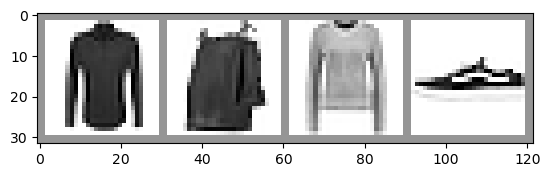

In [18]:
# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = dataiter.next()

im_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(im_grid, one_channel=True)


In [19]:
# Default log_dir arguments is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above

writer = SummaryWriter("../output/runs/fashion_mnist_experiment_1")

# Write image data to TensorBoard log dir
writer.add_image("Four Fashion-MNIST Images", im_grid)
writer.flush()

# TO view, start TensorBoard on the command line with 
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/
